In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import constants as cs
from astropy import units as un
%matplotlib inline

In [3]:
if 0:
    r_3d,m1,m2,x,y,z=np.loadtxt('C:\\Users\Sophia Milanov\Documents\Bachelorarbeit\data\\x-y-z.dat', usecols=(1,9,10,30,31,32), unpack=True)
else:
    r_3d,m1,m2,x,y,z=np.loadtxt('/home/milanov/Bachelorarbeit/x-y-z.dat', usecols=(1,9,10,30,31,32), unpack=True)

In [4]:
r_3d=r_3d[1:]
m1=m1[1:]
m2=m2[1:]
x=x[1:]
y=y[1:]
z=z[1:]

In [5]:
r0=0.01
step=15
end=100
stepsize=((np.log10(end)-np.log10(r0))/step)
R=np.zeros(step)
r=np.logspace(np.log10(r0),np.log10(end),step+1)
r_i=r[:-1:]
r_a=r[1::]
binwidth=r_a-r_i
r_error=binwidth/2


In [6]:
M = np.zeros(step)
rho=np.zeros(step)

for n in range(step):
    inbin=(r_i[n]<r_3d) * (r_3d<=r_a[n]) #r_3d wird verwendet! creates boolean arrays woth true values if star is in bin distance
    M[n]=np.sum(m1[inbin])+np.sum(m2[inbin]) #mass array with both masses of binary system
    rho[n]=M[n]/((r_a[n]**2-r_i[n]**2)*np.pi) #calculates density of bin
    R[n]=np.mean(r_3d[inbin]) #calculates mean distance of bin
    
#extrabin am anfang
M_extra=np.sum(m1[r_3d<r0])+np.sum(m2[r_3d<r0])
rho_extra=M_extra/(r0**2*np.pi)
R_extra=np.mean(r_3d[r_3d<r0])
#einfuegen in bereits angefertigte arrays an erster Stelle
M_final=np.insert(M,0,M_extra)
rho_final=np.insert(rho,0,rho_extra)
R_final=np.insert(R,0,R_extra)

rho_relerror=-2*r_error/R_final[1:]
rho_error=rho_relerror*rho_final[1:]

s = interpolate.InterpolatedUnivariateSpline(np.log(R_final[:]), np.log(rho_final[:]))
R_new=np.logspace(-3,2,1000)
rho_int=np.exp(s(np.log(R_new)))

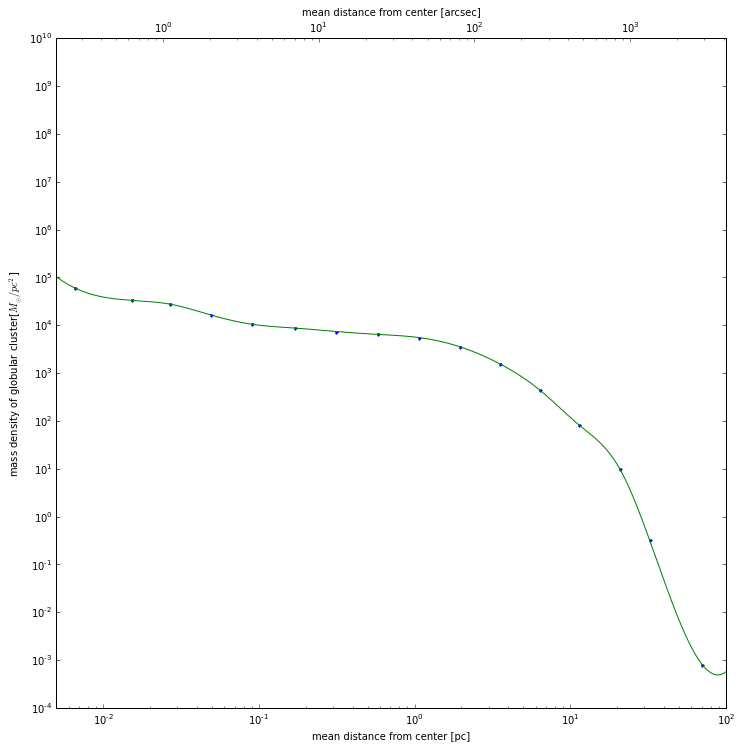

In [7]:
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.loglog(R_final,rho_final,'.')
ax1.loglog(R_new,rho_int)
ax1.set_xlim(0.005,100)
ax1.set_xlabel('mean distance from center [pc]')
ax1.set_ylabel('mass density of globular cluster[$M_\odot/pc^2$]')



ax2.set_xlim((0.005/5000)*360*3600/(2*np.pi),(100./5000)*360*3600/(2*np.pi)) #calculates x limits from parsec to arcsec
ax2.set_xscale('log')
ax2.set_xlabel('mean distance from center [arcsec]')

fig.savefig('3d density profile numerical fit without imbh')

plt.show()


$\Phi(r)=4\pi G \int_{r}^{\infty}r''^2dr''\int_{0}^{r}\rho(r)r'^2dr'$

vereinfacht wegen Kugelsymmetrie: $\Phi(r)=-\frac{G}{r}\int_0^r{\mathrm{d}M(r')}-G\int_r^{\infty}{\frac{\mathrm{d}M(r')}{r'}}=-4\pi G\left[\frac{1}{r}\int_0^r\mathrm{d}r'r'^2\rho(r')+\int_r^{\infty}\mathrm{d}r'r'\rho(r')\right]$
rechne mit $f(r')=\rho(r')r'^2$ bzw. $f(r')=\rho(r')r'$


Gauss-Legendre quadrature

$\int_a^b f(x)dx = \frac{b-a}{2}\sum_{i=1}^n w_i f\left(\frac{b-a}{2}x_i+\frac{a+b}{2}\right)$

damit $\Phi(r)=-4\pi G\left[\frac{1}{2}\sum_{i=1}^n w_i\left(\frac{r}{2}x_i+\frac{r}{2}\right)^2\rho\left(\frac{r}{2} x_i+\frac{r}{2}\right)+\frac{\infty-r}{2}\sum_{i=1}^n w_i \left(\frac{\infty-r}{2} x_i + \frac{\infty+r}{2}\right)\rho\left(\frac{\infty-r}{2} x_i + \frac{\infty+r}{2}\right)\right]$

In [72]:
#fuer w_i und x_i
n=20 #ab n=100 wurde diese Methode nicht getestet
x_i,w_i=np.polynomial.legendre.leggauss(n)

In [73]:
#G in pc^3/(kg*s^2)
m_3=un.m*un.m*un.m/(un.kg*un.s*un.s)
pc_3=un.pc**3/(un.kg*un.s**2)
G=m_3.to(pc_3)

In [79]:
#einfach s(x) benutzen
def potential(r):
    sum1=np.zeros(n)
    sum2=np.zeros(n)
    infty=100 #pc
    x1=(r/2)*x_i+r/2
    x2=((infty-r)/2)*x_i+(infty+r)/2
    for i in range(n):
        if x1[i]<=80:
            s1=s(x1[i])
        else:
            s1=1e-4
        if x2[i]<=80:
            s2=s(x2[i])
        else:
            s2=1e-4
        sum1[i]=np.sum(w_i[i]*x1[i]**2*s1)
        sum2[i]=np.sum(w_i[i]*x2[i]*s2)
    sum_1=np.sum(sum1)
    sum_2=np.sum(sum2)
    return -4*np.pi*G*(1/2*sum_1+(infty-r)/2*sum_2)
    

In [80]:
potential(10)

-9.3324283283351394e-40

In [81]:
Pot=np.zeros(1000)
for i in range(1000):
    Pot[i]=potential(i/10)

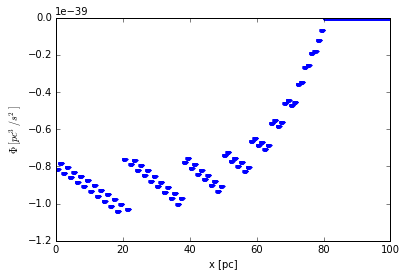

In [85]:
x=np.arange(0,100,0.1)
plt.plot(x,Pot,'.')
plt.xlabel('x [pc]')
plt.ylabel('$\Phi\ [pc^3/s^2]$')

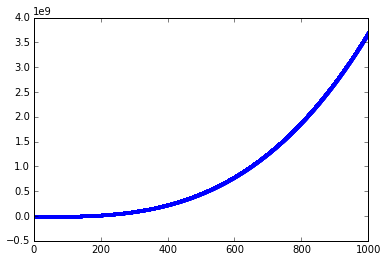

In [83]:

x=np.arange(0,1000,0.1)
plt.plot(x,s(x),'.')